In [20]:
import numpy as np
import scipy
import scipy.stats as sps
import scipy.fftpack as spfft
import scipy.signal as spsig
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.integrate import quad
import scipy.fft as scft
import sys
import stingray as st

sys.path.insert(1, 'C:/Users/shash/UvA/Thesis/Project/MastersThesis/src/MastersThesis/scripts')

from General import *
from PowerSpec import *
from BiSpectra import *
from SimulatorFuncs import *
from CrossBispec import *

In [2]:
from pypalettes import load_cmap
cmap = load_cmap("Classic_Cyclic")
colors = cmap.colors
len(colors)

f = open('C:/Users/shash/UvA/Thesis/Project/MastersThesis/src/MastersThesis/scripts/ColorCycle.txt', 'r')
colors = f.read().replace(' ', '').split(',')

In [3]:
paper_dir = '../../paper/'
save_dir = f'{paper_dir}Figures/SimulatingQPOExample/'

In [4]:
def get_indices_temp(freq, min, max):
    return np.argmin(np.abs(freq-min)), np.argmin(np.abs(freq-max))

def dbl_lorentz_fwhm_and_QPO(f, lor_rmssq1, f_cent1, fwhm1, lor_rmssq2, f_cent2, fwhm2):
    powmod = lorentz_fwhm(f, lor_rmssq1, f_cent1, fwhm1) + lorentz_fwhm(f, lor_rmssq2, f_cent2, fwhm2) + lorentz_fwhm(f, lor_rmssq3, f_cent3, fwhm3)
    return powmod

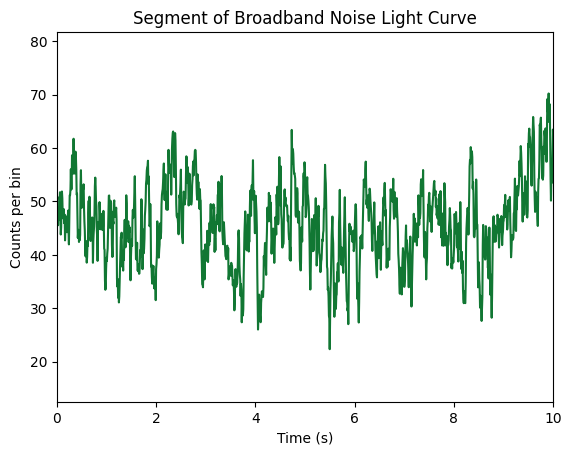

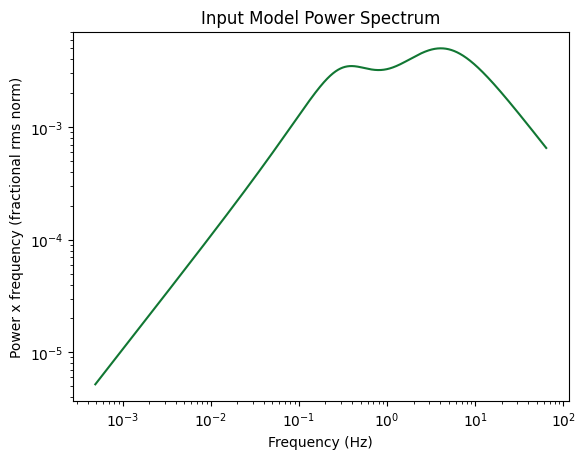

In [64]:
psmodel = dbl_lorentz_fwhm
pspar = [.01, .16, 2*.29, 0.03, 0, 2*4.3] # Strong BBN
# pspar = [.005, .16, 2*.29, 0.01, 0, 2*4.3]
# lor_rmssq, f_cent, fwhm, lor_rmssq, f_cent, fwhm

# Simulated Light Curve Parameters
dt = 1/128 # Time bin size
ntimes = 262144 # Length of light curve 
expquery = 'n' # exponentiation to make the light curve flux distribution lognormal

# Cannot set rms using my newly defined dbl_lorentz_fwhm function!
rms = 0. # Set to 0 to not re-normalize

f_min = 1./(dt*ntimes) # The minimum frequency is 1/(duration of light curve)
f_max = 1/(2.*dt) # The maximum 'Nyquist' frequency is 1/(2*sampling-interval) (i.e. 1/(2*binsize)
params = tuple(pspar)

lc = simlc(dt, ntimes, expquery, rms, psmodel, pspar)
lc *= 6000 * dt

seg_size=64

time = np.linspace(start=dt, stop=(dt*ntimes), num=ntimes) # Set up times for plotting
minfreq = 1./(ntimes*dt)
freq = np.linspace(start=minfreq,stop=(minfreq*ntimes//2), num=ntimes//2)

plt.figure()
plt.plot(time,lc, c=colors[1])
plt.title('Segment of Broadband Noise Light Curve')
plt.xlim(0, 10)
plt.xlabel('Time (s)')
plt.ylabel('Counts per bin')
# plt.savefig(f'{save_dir}BroadbandNoiseLC_Segment.pdf', dpi=600)
plt.show()

plt.figure()
plt.plot(freq,freq*psmodel(freq,*pspar), c=colors[1])
plt.yscale('log')
plt.xscale('log')
plt.title('Input Model Power Spectrum')
plt.ylabel('Power x frequency (fractional rms norm)')
plt.xlabel('Frequency (Hz)')
# plt.savefig(f'{save_dir}BroadbandNoise_Pspec.pdf', dpi=600)
plt.show()

In [65]:
model = lmfit.models.LorentzianModel(prefix='fund_') + lmfit.models.LorentzianModel(prefix='harm_') + lmfit.models.LorentzianModel(prefix='Bbn1_') + lmfit.models.LorentzianModel(prefix='Bbn2_') + lmfit.models.ConstantModel(prefix='poisson_')
params=lmfit.Parameters()

params.add('fund_amplitude', value=0.01, min=0)
params.add('fund_center', value=2.1, min=0)
params.add('fund_sigma', value=.1, min=0)

params.add('harm_center', expr='2.0*fund_center')
params.add('harm_amplitude', value=0.01, min=0)
params.add('harm_sigma', value=.1, min=0)

params.add('Bbn1_amplitude', value=0.05, min=0)
params.add('Bbn1_center', value=.3, min=0)
params.add('Bbn1_sigma', value=0.5, min=0)

params.add('Bbn2_amplitude', value=0.05, min=0)
params.add('Bbn2_center', value=0, min=0)
params.add('Bbn2_sigma', value=10, min=0)

params.add('poisson_c', value=0.0, min=0)

c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(


Text(0.5, 1.0, 'Segment of output light curve')

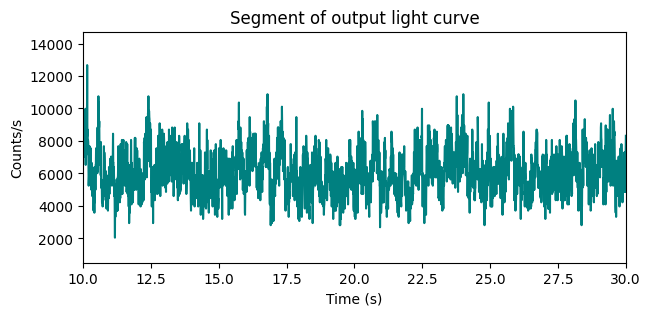

In [76]:
a0 = 0.015
phi1_0 = 0.5*np.pi

# Amplitudes of modulating sinusoid
A1 = .12
A2 = .06

# A1 = 1
# A2 = .5

# Frequency of fundamental and harmonic
nu1 = 2.1
nu2 = 2 * nu1

# Phase difference b/w fundamental and harmonic
psi=.5 * np.pi

# Properties of lorentzian to get stochastic phase variation
nu0 = 0
hwhm = 0.2

# Number of samples needed for the random walk
n_samples = len(time) 


phi_1 = np.cumsum(gen_stochastic_phi(a0=a0, hwhm=hwhm, nu0=nu0, dt=dt, ntimes=ntimes) - 1)
mod = modulation(nu1, nu2, phi_1, A1=A1, A2=A2, psi=psi, times=time)
modulated_ts = lc * mod
modulated_ts = np.random.poisson(modulated_ts)

lc_st = st.Lightcurve(time, modulated_ts, dt=dt)
avg_ps = st.AveragedPowerspectrum.from_lightcurve(lc_st, seg_size, norm='frac')
avg_ps = avg_ps.rebin_log(f=0.02)
pow_err = avg_ps.power_err


fig_lc, ax_lc = plt.subplots(figsize=(7,3))
ax_lc.plot(time, modulated_ts/dt, c='teal')
ax_lc.set_xlim(10,30)
ax_lc.set_ylabel('Counts/s')
ax_lc.set_xlabel('Time (s)')
ax_lc.set_title('Segment of output light curve')

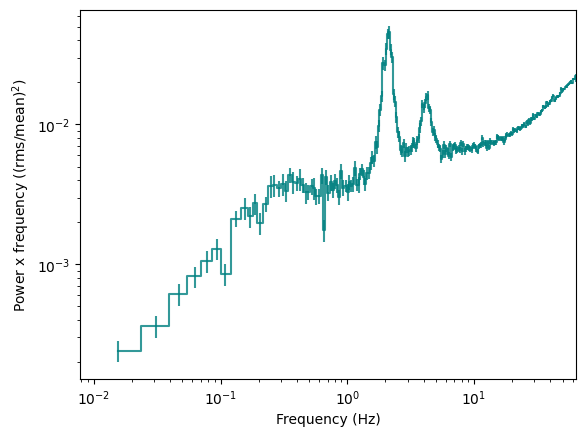

In [77]:
x_dat = avg_ps.freq
y_dat = avg_ps.power
tot_stacked = avg_ps.m

# plot_model_dat(x_dat, y_dat, model, params, title=None, save_name=None, sub_poisson_noise=False, ylim=None, xlim=None)
fit = fit_powerspec(x_dat, y_dat, tot_stacked, model=model, params=params, plot_fit=False)
params_fit=fit.params
# plot_model_dat(x_dat, y_dat, model, params_fit, title=None, save_name=None, sub_poisson_noise=False, ylim=(1e-5, 1e-1), xlim=(1/(128), 1/(2*dt)))

fig_powspec, ax_powspec = plt.subplots()

model_pow = model.eval(params_fit, x=x_dat)

# ax_powspec.plot(x_dat, (model_pow) * x_dat, linestyle='dashed', label='Full Model', c='k')
ax_powspec.errorbar(x_dat, (y_dat) * x_dat, yerr=avg_ps.power_err*x_dat, drawstyle="steps-mid", color="teal", alpha=.8, ls='solid', label='Data')
# print(st.fourier.get_average_ctrate(lc_st))
# for count, mod in enumerate(model.components):
#     if mod.prefix[:-1] != 'poisson':
#         model_pow = mod.eval(params_fit, x=x_dat)
#         ax_powspec.plot(x_dat, (model_pow)* x_dat, linestyle='dashed', label=mod.prefix[:-1], c=colors[count])

ax_powspec.set_xlim(1/(128), 1/(2*dt))
# ax_powspec.set_ylim(5e-5, 1e-1)
ax_powspec.set_xscale('log')
ax_powspec.set_yscale('log')
# ax_powspec.legend()
ax_powspec.set_ylabel(f'Power x frequency ((rms/mean)$^2$)')
ax_powspec.set_xlabel("Frequency (Hz)")


Q_f = fit.params['fund_center'] / (2*fit.params['fund_sigma'])
Q_h = fit.params['harm_center'] / (2*fit.params['harm_sigma'])
# fig_powspec.savefig(f'{save_dir}FullPspecFit.pdf', dpi=600)

In [78]:
fit

# Load fit from an observation

In [79]:
fname='C:/Users/shash/UvA/Thesis/Project/MastersThesis/data/raw/MAXI/ni1050360107_0mpu7_cl.evt'

eventlist = st.EventList.read(fname, "hea") # Load eventlist from file
eventlist = eventlist.filter_energy_range([2, 10])
gtis = eventlist.split_by_gti()
lc_full = eventlist.to_lc(dt=dt)

avg_periodogram = st.AveragedPowerspectrum(lc_full, segment_size=seg_size, norm='frac')
avg_periodogram = avg_periodogram.rebin_log(f=0.04)

poisson_lev = st.fourier.poisson_level('frac', meanrate = st.fourier.get_average_ctrate(eventlist.time, segment_size=64, gti=eventlist.gti))

c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\io.py:744: ResourceWarning: unclosed file <_io.BufferedReader name='C:/Users/shash/UvA/Thesis/Project/MastersThesis/data/raw/MAXI/ni1050360107_0mpu7_cl.evt'>
  self._initialize_header_events(fname, force_hduname=force_hduname)
c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\io.py:1038: ResourceWarning: unclosed file <_io.BufferedReader name='C:/Users/shash/UvA/Thesis/Project/MastersThesis/data/raw/MAXI/ni1050360107_0mpu7_cl.evt'>
  gti_list = get_gti_from_all_extensions(
c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\events.py:632: ResourceWarning: unclosed file <_io.BufferedReader name='C:/Users/shash/UvA/Thesis/Project/MastersThesis/data/raw/MAXI/ni1050360107_0mpu7_cl.evt'>
  evt = FITSTimeseriesReader(
c:\Users\shash\UvA\Thesis\Project\MastersThesis\.venv\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of 

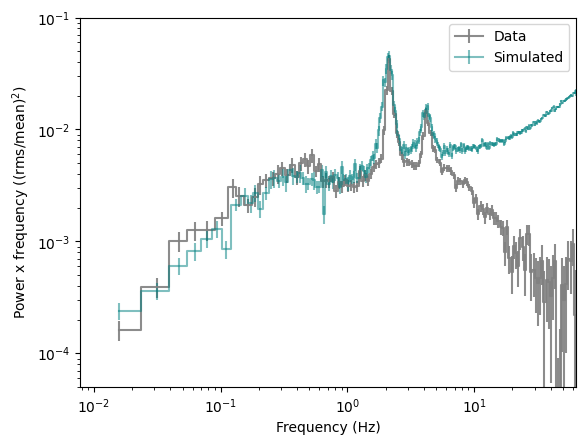

In [80]:
fig_powspec, ax_powspec = plt.subplots()

ax_powspec.errorbar(avg_periodogram.freq, (avg_periodogram.power - poisson_lev) * avg_periodogram.freq, yerr=avg_periodogram.power_err * avg_periodogram.freq,  drawstyle='steps-mid', ls='-', color='grey', label='Data', alpha=.9)

ax_powspec.errorbar(x_dat, (y_dat) * x_dat, yerr=avg_ps.power_err*x_dat, drawstyle="steps-mid", color="teal", alpha=.5, ls='solid', label='Simulated', )

# for count, mod in enumerate(model.components):
#     if mod.prefix[:-1] != 'poisson':
#         model_pow = mod.eval(params_fit, x=x_dat)
#         ax_powspec.plot(x_dat, (model_pow)* x_dat, linestyle='dashed', label=mod.prefix[:-1], c=colors[count])

ax_powspec.set_xlim(1/(128), 1/(2*dt))
ax_powspec.set_ylim(5e-5, 1e-1)
ax_powspec.set_xscale('log')
ax_powspec.set_yscale('log')
ax_powspec.legend()
ax_powspec.set_ylabel(f'Power x frequency ((rms/mean)$^2$)')
ax_powspec.set_xlabel("Frequency (Hz)")

fig_powspec.savefig(f'{save_dir}PowerSpecComparison.pdf', dpi=600)


# Bispectrum

(39, 39)
(39, 39)


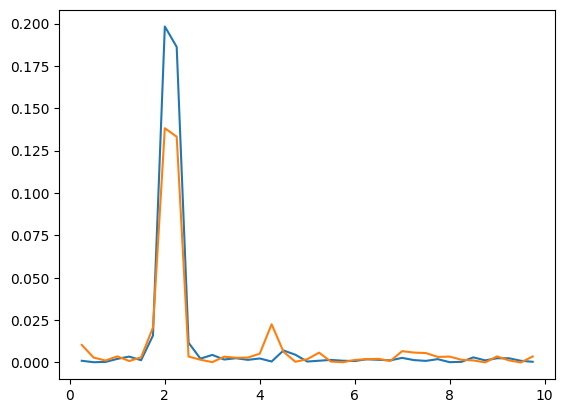

In [83]:
bspec_ss = 8 * 1/2
segmented_counts, segmented_times, n = split_multiple_lc(lc_st.split_by_gti(), bspec_ss, dt=dt)
bspec, freq_bspec, bispec_calcs = avg_bispec(segmented_counts, dt, 0.1, 10, norm = 'bic')
# bspec, freq_bspec = avg_bispec(segmented_counts, dt, 0.1, 10, norm = 'none')
print(bspec.shape)
# plt.pcolor(freq_bspec, freq_bspec, np.abs(bspec), norm='log')
# plt.colorbar()
# plt.show()

plt.plot(freq_bspec, np.diag(np.abs(bspec)))

bspec_ss = 8 * 1/2
segmented_counts, segmented_times, n = split_multiple_lc(lc_full.split_by_gti(), bspec_ss, dt=dt)
bspec, freq_bspec, bispec_calcs = avg_bispec(segmented_counts, dt, 0.1, 10, norm = 'bic')
# bspec, freq_bspec = avg_bispec(segmented_counts, dt, 0.1, 10, norm = 'none')
print(bspec.shape)
# plt.pcolor(freq_bspec, freq_bspec, np.abs(bspec), norm='log')
# plt.colorbar()

plt.plot(freq_bspec, np.diag(np.abs(bspec)))

# plt.show()
# segmented_counts, segmented_times, n = split_multiple_lc(lc_full.split_by_gti(), bspec_ss, dt=dt)
# bspec, freq_bspec, bispec_calcs = avg_cross_bispec(segmented_counts, 0.1, 10, dt, norm = 'none', ret_ind_cbs=True)

# plt.pcolor(freq_bspec, freq_bspec, np.abs(bspec), norm='log')
# plt.colorbar()

In [ ]:
plt.plot(freq_bspec, np.diag(np.abs(bspec)))
